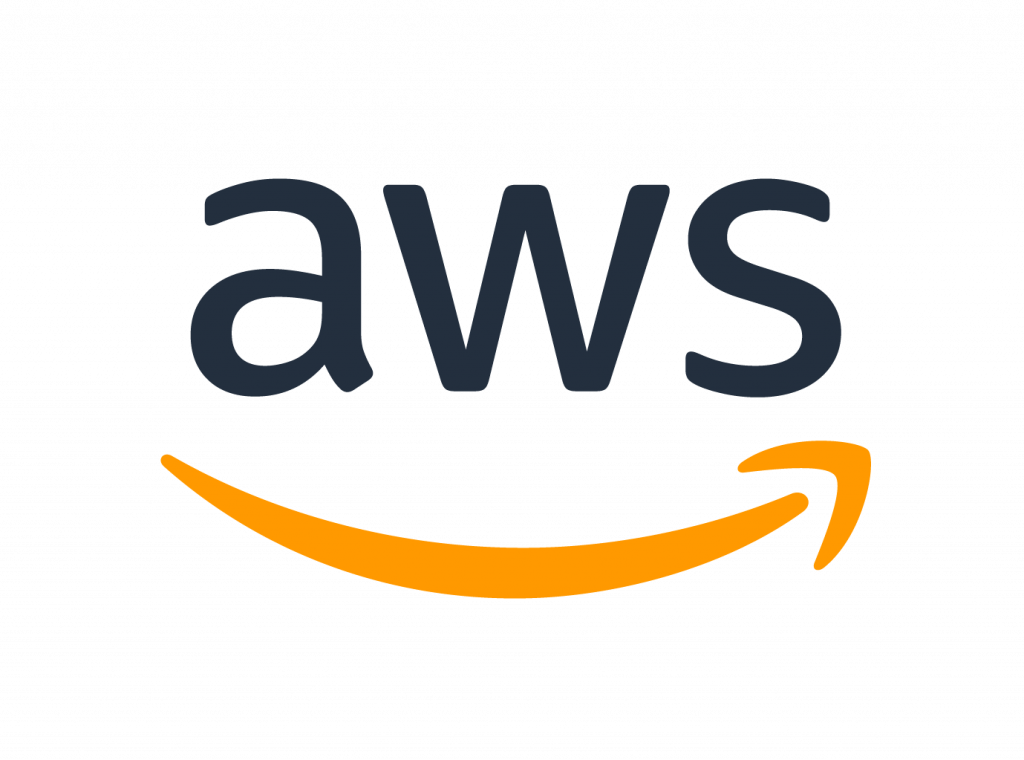

In [1]:
import os
import numpy as np
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import tkinter as tk
from tkinter import scrolledtext

In [2]:
#loading dataset
chatbot = pd.read_csv("AWS_FAQ_Bot.csv")
chatbot.head()

,Question,Answer
0,What is Amazon Elastic Compute Cloud (Amazon E...,Amazon Elastic Compute Cloud (Amazon EC2) is a...
1,What can I do with Amazon EC2?,Just as Amazon Simple Storage Service (Amazon ...
2,How can I get started with Amazon EC2?,"To sign up for Amazon EC2, click the “Sign up ..."
3,Why am I asked to verify my phone number when ...,Amazon EC2 registration requires you to have a...
4,What can developers now do that they could not...,"Until now, small developers did not have the c..."


## 1. Data Preprocessing

In [3]:
chatbot.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 671 entries, 0 to 670
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Question  670 non-null    object
 1   Answer    654 non-null    object
dtypes: object(2)
memory usage: 10.6+ KB


In [4]:
chatbot.isnull().sum()

Question     1
Answer      17
dtype: int64

In [5]:
chatbot.dropna(inplace = True)

In [6]:
chatbot.isnull().sum()

Question    0
Answer      0
dtype: int64

In [7]:
import re
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

def preprocess_text(text):
    # Lowercase
    text = text.lower()
    # Remove punctuation
    text = re.sub(r'[^\w\s]', '', text)
    # Remove numbers
    text = re.sub(r'\d+', '', text)
    # Remove stopwords
    stop_words = set(stopwords.words('english'))
    text = ' '.join(word for word in text.split() if word not in stop_words)
    return text

chatbot['Question_clean'] = chatbot['Question'].apply(preprocess_text)
chatbot['Answer_clean'] = chatbot['Answer'].apply(preprocess_text)


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\DATTA\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## 2. Text Embedding

In [8]:
'''pip install transformers'''

'pip install transformers'

In [9]:
from transformers import BertTokenizer, BertModel
import torch

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertModel.from_pretrained('bert-base-uncased')

def embedtexts(text):
    inputs = tokenizer(text, return_tensors = 'pt', truncation = True, padding = True, max_length = 512)
    outputs = model(**inputs)
    return outputs.last_hidden_state.mean(dim = 1).detach().numpy()
chatbot['Quetion_embedding'] = chatbot['Question'].apply(embedtexts)

C:\Users\DATTA\anaconda3\Lib\site-packages\transformers\utils\generic.py:260: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  torch.utils._pytree._register_pytree_node(


## 3. Matching Question and Answer

In [10]:
# Function to find the best matching answer
def best_answer(user_question, data):
    user_question_clean = preprocess_text(user_question)
    user_question_embedding = embedtexts(user_question_clean)

    similarities = cosine_similarity(user_question_embedding, np.vstack(chatbot['Quetion_embedding'].values))
    best_match_index = np.argmax(similarities)
    return chatbot.iloc[best_match_index]['Answer']

## 4. Creating User Interface

In [11]:
def ask_question():
    user_question = question_entry.get()
    answer = best_answer(user_question, chatbot)
    answer_text.configure(state='normal')
    answer_text.delete(1.0, tk.END)
    answer_text.insert(tk.END, answer)
    answer_text.configure(state='disabled')

root = tk.Tk()
root.title("FAQ Chatbot")

tk.Label(root, text="Ask a question:").pack()
question_entry = tk.Entry(root, width=50)
question_entry.pack()
tk.Button(root, text="Submit", command=ask_question).pack()

answer_text = scrolledtext.ScrolledText(root, height=10, width=50, state='disabled')
answer_text.pack()

root.mainloop()